In [3]:
import pandas as pd
df = pd.read_csv("epl-allseasons-matchstats.csv")

In [4]:
from scipy.stats import ttest_ind
df_ttest = df[['HomeShots', 'AwayShots']].dropna()

t_stat, p_val = ttest_ind(df_ttest['HomeShots'], df_ttest['AwayShots'])

print("T-Statistic:", t_stat)
print("P-Value:", p_val)

T-Statistic: 24.04132913785648
P-Value: 3.7398178024770016e-123


In [5]:
from scipy.stats import wilcoxon
df_wilcoxontest = df[['HomeGoals', 'AwayGoals', "HomeGoalsHalftime", "AwayGoalsHalftime"]].dropna()
df_wilcoxontest["FullTimeGoals"] = df_wilcoxontest["HomeGoals"] + df_wilcoxontest["AwayGoals"]
df_wilcoxontest["FirstHalfGoals"] = df_wilcoxontest["HomeGoalsHalftime"] + df_wilcoxontest["AwayGoalsHalftime"]
df_wilcoxontest["SecondHalfGoals"] = df_wilcoxontest["FullTimeGoals"] - df_wilcoxontest["FirstHalfGoals"]

wilcoxon_stat, p_wilcoxon = wilcoxon(df_wilcoxontest["FirstHalfGoals"], df_wilcoxontest["SecondHalfGoals"])

print("P-Value:", p_wilcoxon)
if p_wilcoxon > 0.05:
    print("Можем да допуснем че имат еднакво разпределение")
else:
    print("Отхвърляме хипотезата")

P-Value: 3.919631814055635e-31
Отхвърляме хипотезата


In [12]:
from scipy.stats import chi2_contingency

london_teams = ["Arsenal","Chelsea","QPR","West Ham","Crystal Palace"]

spurs_matches = df[(df["HomeTeam"] == "Tottenham") | (df["AwayTeam"] == "Tottenham")]

def is_london_derby(row):
    if row["HomeTeam"] == "Tottenham" and row["AwayTeam"] in london_teams:
        return "Derby"
    elif row["AwayTeam"] == "Tottenham" and row["HomeTeam"] in london_teams:
        return "Derby"
    else:
        return "Non-Derby"
    
spurs_matches["MatchType"] = spurs_matches.apply(is_london_derby, axis = 1)

def spurs_result(row):
    if row['HomeTeam'] == 'Tottenham':
        if row['FullTime'] == "HomeWin":
            return 'Win'
        elif row['FullTime'] == "AwayWin":
            return 'Loss'
        else:
            return 'Draw'
    else:
        if row['FullTime'] == "AwayWin":
            return 'Win'
        elif row['FullTime'] == "HomeWin":
            return 'Loss'
        else:
            return 'Draw'

spurs_matches['SpursResult'] = spurs_matches.apply(spurs_result, axis=1)

contingency_table = pd.crosstab(spurs_matches["MatchType"], spurs_matches["SpursResult"])

chi2, p_value_chi, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic: {chi2}")
print(f"P-Value: {p_value_chi}")
print(f"Degrees of Freedom: {dof}")


Chi-Square Statistic: 3.2850878571788327
P-Value: 0.19348719806158418
Degrees of Freedom: 2


C:\Users\m.stefanov\AppData\Local\Temp\ipykernel_11416\3947592643.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spurs_matches["MatchType"] = spurs_matches.apply(is_london_derby, axis = 1)
C:\Users\m.stefanov\AppData\Local\Temp\ipykernel_11416\3947592643.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spurs_matches['SpursResult'] = spurs_matches.apply(spurs_result, axis=1)


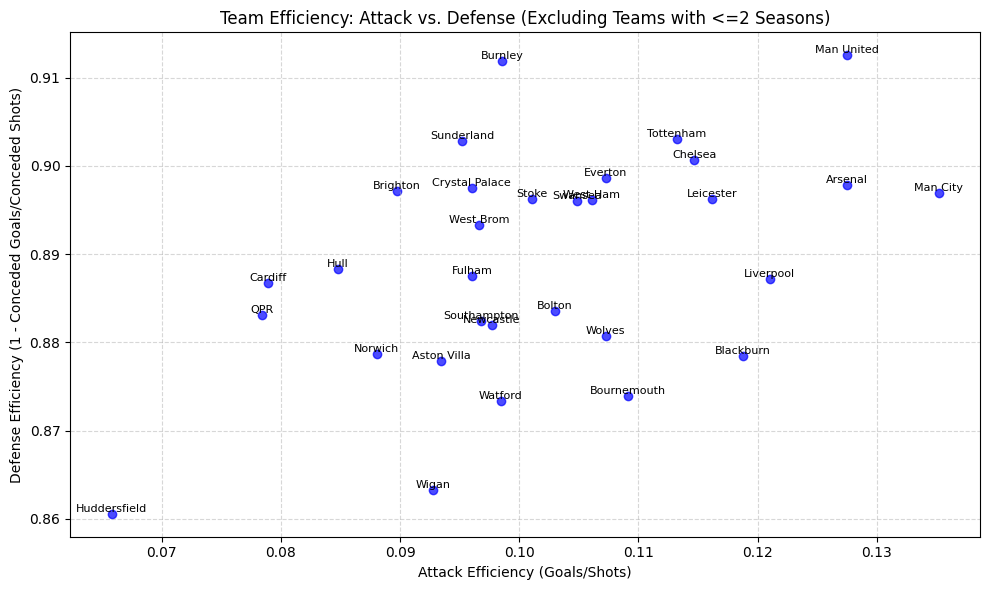

In [18]:
import matplotlib.pyplot as plt

home_seasons = df.groupby("HomeTeam")["Season"].nunique()
away_seasons = df.groupby("AwayTeam")["Season"].nunique()
total_seasons = (home_seasons + away_seasons).dropna()

eligible_teams = total_seasons[total_seasons >= 3].index

filtered_df = df[
    (df["HomeTeam"].isin(eligible_teams)) &
    (df["AwayTeam"].isin(eligible_teams))
]

home_attack = filtered_df.groupby("HomeTeam").agg({"HomeGoals": "sum", "HomeShots": "sum"})
away_attack = filtered_df.groupby("AwayTeam").agg({"AwayGoals": "sum", "AwayShots": "sum"})
attack_efficiency = (home_attack["HomeGoals"] + away_attack["AwayGoals"]) / (home_attack["HomeShots"] + away_attack["AwayShots"])

home_defense = filtered_df.groupby("HomeTeam").agg({"AwayGoals": "sum", "AwayShots": "sum"})
away_defense = filtered_df.groupby("AwayTeam").agg({"HomeGoals": "sum", "HomeShots": "sum"})
defense_efficiency = 1 - (home_defense["AwayGoals"] + away_defense["HomeGoals"]) / (home_defense["AwayShots"] + away_defense["HomeShots"])

efficiency_df = pd.DataFrame({
    "Attack Efficiency": attack_efficiency,
    "Defense Efficiency": defense_efficiency
}).dropna()

plt.figure(figsize=(10, 6))
plt.scatter(
    efficiency_df["Attack Efficiency"],
    efficiency_df["Defense Efficiency"],
    alpha=0.7,
    color="blue"
)

for team in efficiency_df.index:
    plt.text(
        efficiency_df.loc[team, "Attack Efficiency"],
        efficiency_df.loc[team, "Defense Efficiency"],
        team,
        fontsize=8,
        ha="center",
        va="bottom"
    )

plt.xlabel("Attack Efficiency (Goals/Shots)")
plt.ylabel("Defense Efficiency (1 - Conceded Goals/Conceded Shots)")
plt.title("Team Efficiency: Attack vs. Defense (Excluding Teams with <=2 Seasons)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()